# Clustering Analysis on Selected Texts Using NLP

The aim of this project is to group a disparate collection of short texts using unsupervised learning techniques. To facilitate this, the texts will first be parsed using Natural Language Processing, commonly referred to its abbreviation NLP. NLP is a field within data science that interprets written or spoken data by characterizing constituent words or phrases. This powerful and increasingly widely used technique will be used to define each individual text using a technique known as vectorization, which will be explained in detail later. The analytical choices and decisions made will be discussed along the way. More formally, the goals of this project can be summarized as follows:
-  To use several different clustering methods to group the texts.
-  To evaluate and validate, using other techniques, the quality of the clustering obtained.

## The Corpus

The corpus to be studied consists of 105 short stories downloaded from various sources on the internet. Sources include the Gutenberg Project and textfiles.com. Authors range from Jack London to Emile Zola, to Fyodor Dostoevsky, to a number of lesser-known authors. The texts are drawn from the romance, science fiction, detective and occult genres. Texts that cannot be easily identified as being from any of those genres are classified as 'miscellaneous'. In the analysis, each text will be identified by its author and title, and categorized according to its genre and the collection, if applicable, from which it was taken. Publication dates span the period from 1880 to 1992. The full listing of text titles is shown in the 'Data Import and Cleaning' section.

## Import the Required Packages

In [1]:
import time
import glob
import errno
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import spatial
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

## Data Import and Cleaning

Being a corpus of selected short stories, rather than a conventional table of data values, the dataset did not contain erroneous or questionable values as such. What it did contain, though, were a number of backslashes from the filepath extensions, unneeded dashes, and trailing and leading spaces. In addition, the entire corpus had to be converted to lower case for consistency. In all, the corpus was considerably easier and faster to clean than a more diverse dataset with multiple different datatypes. One key decision made was to consider only a portion of each text, due to the limited available processor power. As such, texts were limited to the first 6000 characters, which is roughly equivalent to two pages. In addition to ensuring that the CPU could handle the whole corpus, this step served to 'equalize' the corpus. That is to say, it ensured that all texts were roughly the same length (only roughly because a small number of them were shorter than 6000 characters to begin with). Thus any 'class imbalance' resulting from widely disparate text lengths was significantly reduced. 

In [2]:
# Define the path where the files reside
path = 'C://Users//fergu//Collections2/*.txt'
files = glob.glob(path)
# Create lists to hold the data
author = []
title = []
year = []
collection = []
genre = []
text = []

# Read in the files one by one. Populate lists containing the title,
# author, year, genre and collection of each text. These will be useful
# later as an easy reference when working with other tables that contain
# only numerical data.

for filename in files:       
    try:
        with open(filename, encoding='Latin-1') as f:
            title.append(filename.split('-')[0])
            author.append(filename.split('-')[1])
            year.append(filename.split('-')[2])
            collection.append(filename.split('-')[3])
            genre.append(filename.split('-')[4])        
            text.append(f.read())       
    except IOError as exc:
        if exc.errno != errno.EISDIR:
            raise

In [3]:
# Check one of the titles
title[64]

'C://Users//fergu//Collections2\\the eyes of the panther '

In [4]:
# Remove filepath and file extension characters
genre = [ge.split('.')[0] for ge in genre]
title = [ti.split('\\')[1] for ti in title]

In [5]:
# Verify that the dataset has the right no. of texts
len(text)

105

In [6]:
# Remove any trailing and leading spaces from names
title = [item[1:] if item[0] == ' ' else item for item in title]
title = [item[:-1] if item[-1] == ' ' else item for item in title]

author = [item[1:] if item[0] == ' ' else item for item in author]
author = [item[:-1] if item[-1] == ' ' else item for item in author]

genre = [item[1:] if item[0] == ' ' else item for item in genre]
genre = [item[:-1] if item[-1] == ' ' else item for item in genre]

year = [item[1:] if item[0] == ' ' else item for item in year]
year = [item[:-1] if item[-1] == ' ' else item for item in year]

collection = [item[1:] if item[0] == ' ' else item for item in collection]
collection = [item[:-1] if item[-1] == ' ' else item for item in collection]

In [7]:
# A look at the full listing of 105 titles
# Note that titles are zero-indexed, 
# so title indices run from 0 to 104
# To determine the index of a specific text, add its 
# row number to the first number of its column identifier
# e.g. The Only Girl at Overlook: 14 + 63 = 77
key = pd.DataFrame({'0-20':title[:21], '21-41':title[21:42], '42-62':title[42:63], '63-83':title[63:84], '84-104':title[84:]})
key

,0-20,21-41,42-62,63-83,84-104
0,100 west by 53 north,bitter sweet,once upon a mattress,the end of all,the pit and the pendulum
1,a day's lodging,bobok,painkiller,the eyes of the panther,the portal of the unknown
2,a ghost,brown wolf,photographing invisible beings,the gift of the magi,the problem with time travel
3,a lion and a lioness,captain burle,prints of the city,the gold brick,the quicksand
4,a lost day,desiree's baby,rain dance mechwarrior fan fiction,the heavenly christmas,the reckoning
5,a novel in nine letters,expiation,shall he marry her,the informer,the repairman
6,a pair of silk stockings,flint and fire,some remarkable psychic experiences of famous ...,the kiss,the return
7,a reflection,freya of the seven isles,strange adventures of a million dollars,the lady's maid's bell,the right promethean fire
8,a respectable woman,gambler's world,the awakening,the land of heart's desire,the riverman
9,a smile of fortune,gaspar ruiz,the brute,the letter,the second generation


In [8]:
# Determine the mean length of the texts 
char_lengths = []
for story in text:
    char_lengths.append(len(story))
print('Average no. of characters: {}'.format(np.mean(char_lengths)))

Average no. of characters: 56010.990476190476


In [9]:
# Create a dictionary housing all the descriptive info
my_dict = {}
my_dict['title'] = title
my_dict['author'] = author
my_dict['year'] = year
my_dict['collection'] = collection
my_dict['genre'] = genre

In [10]:
# Reduce each text to the first 6000 characters and add into the dictionary
my_dict['text'] = [story[:5999] if len(story) > 6000 else story for story in text]

In [11]:
# Check new mean length - less than 6000 because some
# of the texts were already shorter than 6000 characters
char_lengths2 = [len(extract) for extract in my_dict['text']]
np.mean(char_lengths2)

5920.4285714285716

In [12]:
# Remove certain unneeded characters and words
pattern = "[\\[].*?[\\]]"
for i in range(len(my_dict['text'])):
    my_dict['text'][i] = ' '.join(my_dict['text'][i].split())
    my_dict['text'][i] = my_dict['text'][i].lower()
    my_dict['text'][i] = re.sub(r'--',' ',my_dict['text'][i])
    my_dict['text'][i] = re.sub(pattern,'',my_dict['text'][i])
    my_dict['text'][i] = re.sub(r'Chapter \d+','',my_dict['text'][i])
    my_dict['text'][i] = re.sub(r'CHAPTER \d+','',my_dict['text'][i])
    my_dict['text'][i] = re.sub(r'chapter \d+','',my_dict['text'][i])

## Preliminary Analysis

In [13]:
# Create a dataframe for easy visual reference
df = pd.DataFrame({'title':my_dict['title'], 'author':my_dict['author'], 'year':my_dict['year'],
                   'text':my_dict['text'], 'collection': my_dict['collection'], 'genre':my_dict['genre']
                  })

In [14]:
# A quick look at the dataframe
df.head()

,author,collection,genre,text,title,year
0,jim prentice,none,misc,"north of 53. a magic phrase. spoken, mumbled o...",100 west by 53 north,1990
1,jack london,jacklss,misc,it was the gosh-dangdest stampede i ever seen....,a day's lodging,1913
2,lafcadio hearn,best_psych,occult,perhaps the man who never wanders away from th...,a ghost,1920
3,Joaquin Miller,11poss,detective,chapter i. i doubt if you will find either pro...,a lion and a lioness,1891
4,edgar fawcett,11poss,detective,"""my family,"" john dalrymple would say, ""have t...",a lost day,1891


### Examining the Corpus Visually

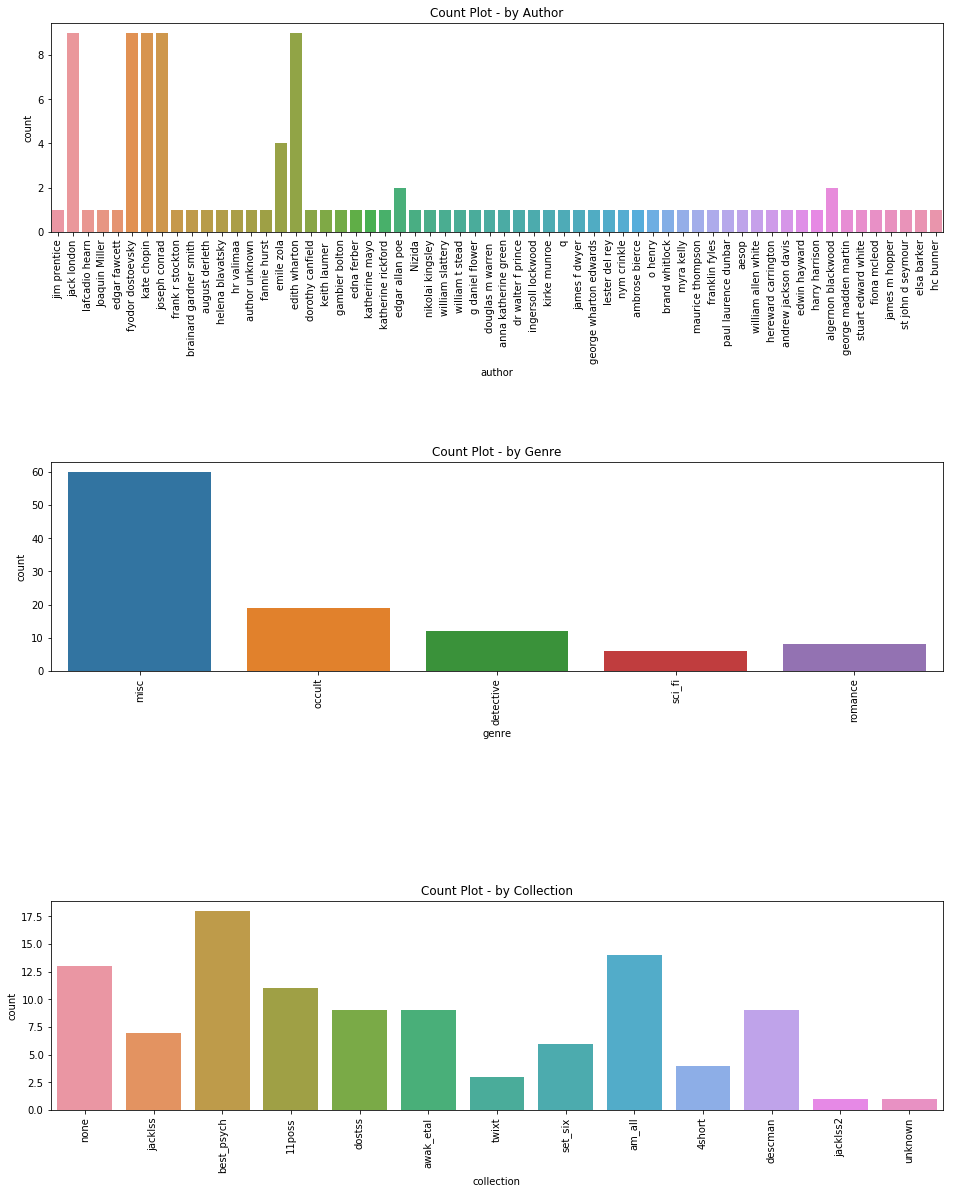

In [15]:
# Create three subplots for visual exploration
plt.figure(figsize=(16,20))
plt.subplot(3,1,1)
plt.subplots_adjust(hspace=1.1)
sns.countplot(x=df['author'])
plt.xticks(rotation=90)
plt.title('Count Plot - by Author')
plt.subplot(3,1,2)
sns.countplot(x=df['genre'])
plt.xticks(rotation=90)
plt.title('Count Plot - by Genre')
plt.subplot(3,1,3)
sns.countplot(x=df['collection'])
plt.xticks(rotation=90)
plt.title('Count Plot - by Collection')
plt.show()

### The TF-IDF Vectorizer
In order to analyze and compare the texts, they first have to be vectorized. This entails the creation, for each text, of an n x 1 matrix, where n is the number of words within that text (vectorization can also be done sentence-by-sentence but we will do it in such a way that each full text is represented by a single matrix). Each word in the text is then given a coefficient that will be its representative value in the matrix or vector. How this coefficient is calculated is what distinguishes one vectorization model from another. The Bag-of-Words model, for example, is a simple model that increments the coefficient by one for every time it appears. The TF-IDF (Term Frequency-Inverse Document Frequency) model is more nuanced; it approaches this by assigning a word a higher weighting if it appears several times within a specific text (i.e. it has a high term frequency). On the other hand, that word is penalized, meaning it weighting is reduced, if it also appears frequently in other members of the corpus (hence the inverse document frequency). In calling the TF-IDF vectorizer, a number of parameters are passed. These are shown and briefly commented in the code below.

#### Stop-words
Stop-words are words within a body of text that act as connectors. Examples of common stop-words are 'and', 'but', 'the', and 'to'. While useful and necessary in written and verbal language, stop-words do not themselves carry a lot of meaning. For that reason, stop-words are usually omitted from NLP analyses. The sci-kit learn TF-IDF method call contains a 'stop_words' parameter as shown.

In [16]:
# Instantiate scikit-learn's tfidf vectorizer 
vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the texts
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, # convert everything to lower case (a redundancy since this was done in the data-cleaning section)
                             use_idf=True, # we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', # Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True # Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

In [17]:
# Fit the vectorizer to the dataframe's 'text' column
# thereby creating a vector version of the corpus
start_time = time.time()
text_tfidf = vectorizer.fit_transform(df['text'])
interval = time.time() - start_time
print('Time taken: {} seconds'.format ('%.1f' % interval))

Time taken: 0.4 seconds


In [18]:
# Convert to Compressed Sparse Row (CSR) format
text_tfidf_csr = text_tfidf.tocsr()

#### An example of a TF-IDF-vectorized text 
Below we see one of the texts under consideration, followed by its representative TF-IDF vector. Note that the vectorized version is free of stop-words.

In [19]:
# Number of extracts
n = text_tfidf_csr.shape[0]
# A list of dictionaries, one per text
tfidf_bytext = [{} for _ in range(0,n)]
# List of features
terms = vectorizer.get_feature_names()
# For each text, list the feature words and their tf-idf scores
for i, j in zip(*text_tfidf_csr.nonzero()):
    tfidf_bytext[i][terms[j]] = text_tfidf_csr[i, j]

print('Original text:', df.iloc[6,3])
print('\n', '*' * 60, '\n')
print('Tf_idf vector:', tfidf_bytext[6])

Original text: little mrs. sommers one day found herself the unexpected possessor of fifteen dollars. it seemed to her a very large amount of money, and the way in which it stuffed and bulged her worn old porte-monnaie gave her a feeling of importance such as she had not enjoyed for years. the question of investment was one that occupied her greatly. for a day or two she walked about apparently in a dreamy state, but really absorbed in speculation and calculation. she did not wish to act hastily, to do anything she might afterward regret. but it was during the still hours of the night when she lay awake revolving plans in her mind that she seemed to see her way clearly toward a proper and judicious use of the money. a dollar or two should be added to the price usually paid for janie's shoes, which would insure their lasting an appreciable time longer than they usually did. she would buy so and so many yards of percale for new shirt waists for the boys and janie and mag. she had intende

## Analyzing the Vectorized Dataset
We begin this section by determining the level of correlation, or similarity, between the vectorized texts using cosine similarity. We first create a similarity table consisting of cosine similarity coefficients between all of the texts contained in the corpus.

In [20]:
# Create an empty similarity table for the texts
sim_table = pd.DataFrame(columns = np.arange(105), index = np.arange(105))

# Populate the similarity table using cosine similarity
# Indices and columns correspond to the original list indices of the 105 texts
for i in range(len(sim_table.columns)):
    sim_table[i] = [(1 - spatial.distance.cosine(text_tfidf_csr[i].toarray(), text_tfidf_csr[j].toarray()))
                     for j in range(0,105)]

In [21]:
# A glance at the table
sim_table.head()

,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,104
0,1.000000,0.090097,0.056543,0.051436,0.040065,0.010974,0.037537,0.011624,0.041589,0.046840,...,0.033467,0.061785,0.048641,0.036281,0.034581,0.017277,0.029681,0.047155,0.032128,0.054363
1,0.090097,1.000000,0.034175,0.056049,0.044609,0.035217,0.047963,0.043427,0.070571,0.056070,...,0.041520,0.064290,0.099826,0.084418,0.034678,0.016335,0.035019,0.063741,0.146893,0.099819
2,0.056543,0.034175,1.000000,0.083692,0.084469,0.055276,0.047095,0.050602,0.081823,0.047379,...,0.069103,0.058496,0.037999,0.046690,0.071708,0.073923,0.063119,0.069488,0.055525,0.028890
3,0.051436,0.056049,0.083692,1.000000,0.093668,0.068106,0.047073,0.038839,0.070895,0.094885,...,0.088330,0.089227,0.052221,0.042126,0.079899,0.065067,0.031394,0.089410,0.056210,0.066192
4,0.040065,0.044609,0.084469,0.093668,1.000000,0.113330,0.086754,0.029015,0.107143,0.082655,...,0.076436,0.054275,0.048847,0.040845,0.103270,0.089440,0.080068,0.057443,0.037662,0.030935


In [22]:
# Determine vmax and vmin, the highest and lowest
# values in our correlation table
col_maxes = [sim_table[i].sort_values(ascending=False).reset_index()[i][1] 
             for i in range(0, len(sim_table))]
v_max = np.max(col_maxes)

col_mins = [sim_table[i].sort_values(ascending=True)[0] for i in range(0, len(sim_table))]
v_min = np.min(col_mins)

print('vmax: {}'.format(v_max))
print('vmin: {}'.format(v_min))

vmax: 0.363524104126409
vmin: 0.009643932660654442


### A Look at cosine Similarity via a Heatmap
Below we see the heatmap generated from our cosine similarity table, with the indexed title key below that. Clearly most of the texts have very low correlation with one another. There are, however, a number of text-text relationships where texts correlate better with esch other, having cosine similarity values greater than 0.2. These blocks show up on the plot in greenish hues. 

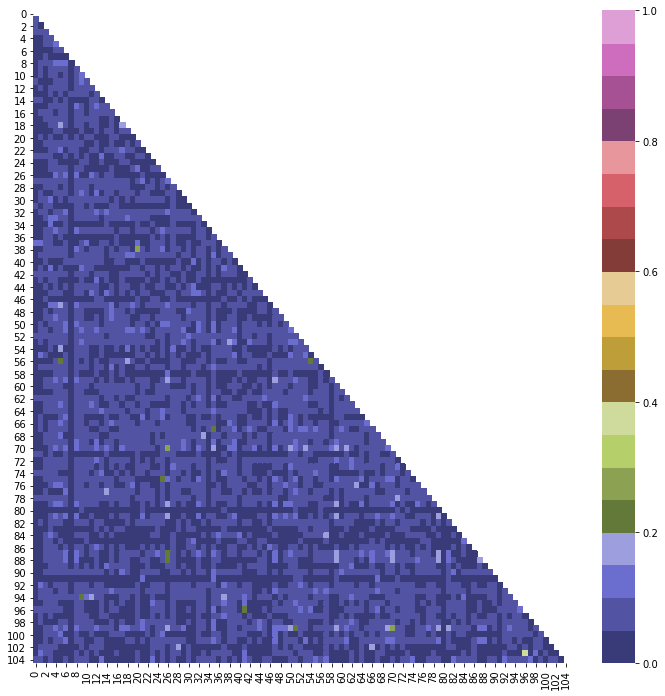

In [23]:
# Show heatmap for the correlation
fig = plt.figure(figsize=(12,12))
# Define a mask so that only one half is displayed
mask = np.zeros_like(sim_table, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(sim_table, cmap="tab20b", mask=mask, vmin=0, vmax=1)
plt.show()

In [24]:
# A key for the plot
key

,0-20,21-41,42-62,63-83,84-104
0,100 west by 53 north,bitter sweet,once upon a mattress,the end of all,the pit and the pendulum
1,a day's lodging,bobok,painkiller,the eyes of the panther,the portal of the unknown
2,a ghost,brown wolf,photographing invisible beings,the gift of the magi,the problem with time travel
3,a lion and a lioness,captain burle,prints of the city,the gold brick,the quicksand
4,a lost day,desiree's baby,rain dance mechwarrior fan fiction,the heavenly christmas,the reckoning
5,a novel in nine letters,expiation,shall he marry her,the informer,the repairman
6,a pair of silk stockings,flint and fire,some remarkable psychic experiences of famous ...,the kiss,the return
7,a reflection,freya of the seven isles,strange adventures of a million dollars,the lady's maid's bell,the right promethean fire
8,a respectable woman,gambler's world,the awakening,the land of heart's desire,the riverman
9,a smile of fortune,gaspar ruiz,the brute,the letter,the second generation


### A Further Look at cosine Similarity
Four more heatmaps were created, this time with texts grouped by author, collection, genre and year of publication. This proved fruitless; no coherent pattern can be discerned from the heatmaps when the data are grouped in this way.

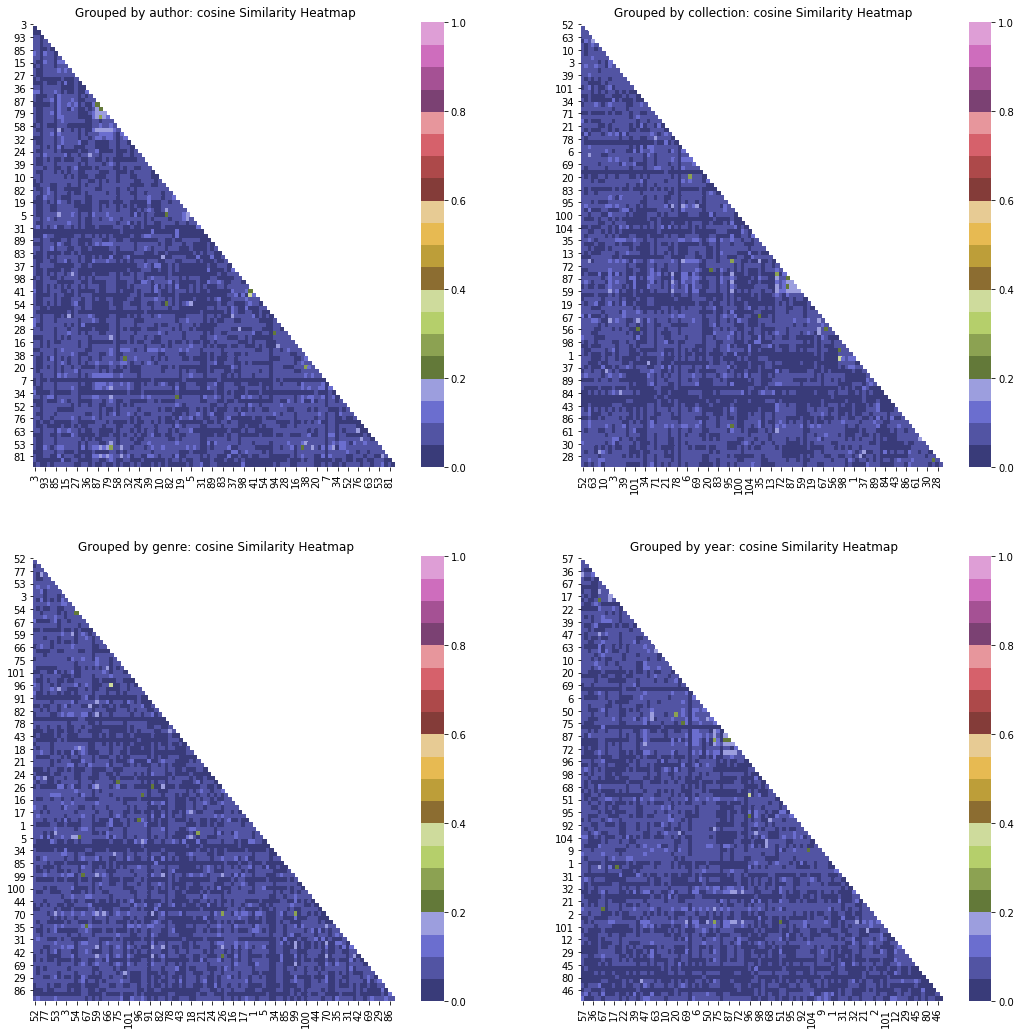

In [25]:
plt.rcParams['figure.figsize'] = (18.0, 18.0)
# Create lists to hold the plot data
heat_attr = [author, collection, genre, year]
heat_names = ['author', 'collection', 'genre', 'year']
heat_list = []
for i in range(0, 4):
    # Compute index:
    sim_table_sort = pd.DataFrame(
        columns = df.sort_values(by=heat_names[i]).index, 
        index = df.sort_values(by=heat_names[i]).index)  
    # Compute cosine distances as before:
    for col in sim_table_sort.columns:
        sim_table_sort[col] = [(1 - spatial.distance.cosine(text_tfidf_csr[col].toarray(), text_tfidf_csr[row].toarray()))
                              for row in sim_table_sort.index]
    heat_list.append(sim_table_sort)
        
# Plot results on separate subplot axes:    
for m in range(len(heat_list)):
    plt.subplot(2,2,m+1)
    mask = np.zeros_like(sim_table, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(heat_list[m], cmap="tab20b", mask=mask, vmin=0, vmax=1)
    plt.title('Grouped by {}: cosine Similarity Heatmap'.format(heat_names[m]))
plt.show()

### Splitting the Data Into Training and Test Sets
The corpus will next be split into training and test sets. The first 84 (out of 105) are thus designated as the training set. The holdout set, the remaining 21 texts, will be used for predictive and comparative analysis later.

In [26]:
# Define the reduced similarity table for the training set
sim_table_84 = sim_table.iloc[:84][:84]

In [27]:
# Put all values in the similarity table into a list
sim_table_84_values = []
for i in range(len(sim_table_84.index)):
    for j in range(len(sim_table_84.columns)):
        sim_table_84_values.append(sim_table_84.iloc[i,j])

In [28]:
# Put all similarity values into a single-column dataframe
# This is only so that we can look at the statistical data (below)
std_table = pd.DataFrame(sim_table_84_values)
# Remove the 1.0 values as these denote the similarity of a text with 
# itself. These are trivial and will bias the stat results
std_table = std_table.drop([row for row in std_table.index if std_table.iloc[row,0] > 0.99])

In [29]:
# View stats
std_table[0].describe()

count    8736.000000
mean        0.058815
std         0.026534
min         0.005831
25%         0.040644
50%         0.054660
75%         0.071858
max         0.262329
Name: 0, dtype: float64

In [30]:
# Define variables for the mean and 
# standard deviation of the cosine similarity
st_d = np.std(std_table[0])
mean = np.mean(std_table[0])

### Examining the Highest and Lowest Similarity Pairs
We next look at the text pairs that show the highest and lowest similarity according to their cosine similarity. To do this, we will define a threshold value above and below the mean, which will serve as the cut-off point for these highest and lowest similarities. The number that gives a reasonable number of values in both cases is 1.5 standard deviations. This leads to 163 highest-similarity pairs (2.3% of approx. 6972 possible text-text pairings) and 79 lowest-similarity pairs (1.1% of all possible text-text pairings). 

In [31]:
# Define threshold value, above which cosine  
# similarities are to be considered 'high'
threshold = mean + 1.5 * st_d
threshold

0.09861340588107614

In [32]:
# Produce a high-correlation table - a table showing the lowest 
# cosine-similarity pairs (cosine_sim > 1.5 standard deviations above the mean)

row_indices = []
col_indices = []

for i in range(len(sim_table_84.index)):
    for j in range(len(sim_table_84.columns)):
        if sim_table_84.iloc[i,j] > threshold and i != j and i not in col_indices: 
            row_indices.append(i)
            col_indices.append(j)
# Create a dictionary to hold all the texts, similarity scores, authors and years of publication
high_sim_table_84 = pd.DataFrame({'text_1': [title[value] for value in row_indices],
                               'text_2': [title[value] for value in col_indices],
                               'cosine_sim': 
                                [sim_table_84.iloc[row_indices[k],col_indices[k]] for k in range(len(row_indices))],
                               'author_1': [author[value] for value in row_indices],
                               'author_2': [author[value] for value in col_indices],
                               'year_1': [year[value] for value in row_indices],
                               'year_2': [year[value] for value in col_indices]})
# Create list to ensure columns are displayed in the desired order
cols = ['cosine_sim', 'author_1', 'author_2', 'text_1', 'text_2', 'year_1', 'year_2']
high_sim_table_84 = high_sim_table_84.sort_values(by='cosine_sim', ascending=False)[cols]
high_sim_table_84.head()

,cosine_sim,author_1,author_2,text_1,text_2,year_1,year_2
79,0.260156,kate chopin,kate chopin,beyond the bayou,ma'ame pelagie,1891,1899
108,0.224760,james f dwyer,fyodor dostoevsky,the citizen,the crocodile,1915,1865
149,0.212874,edith wharton,kate chopin,the mission of jane,desiree's baby,1902,1894
48,0.200812,joseph conrad,joseph conrad,a smile of fortune,the secret sharer,1910,1910
89,0.198427,joseph conrad,jack london,freya of the seven isles,the unexpected,1910,1906


In [33]:
# Re-define threshold, this time below the mean
threshold = mean - 1.5 * st_d
threshold

0.019016385544853194

In [34]:
# Produce a low-correlation table - a table showing the lowest 
# cosine-similarity pairs (cosine_sim < 1.5 standard deviations below the mean)

row_indices = []
col_indices = []

for i in range(len(sim_table_84.index)):
    for j in range(len(sim_table_84.columns)):
        if sim_table_84.iloc[i,j] < threshold and i != j and i not in col_indices: 
            row_indices.append(i)
            col_indices.append(j)
# Create a dictionary to hold all the texts, similarity scores, authors and years of publication
low_sim_table_84 = pd.DataFrame({'text_1': [title[value] for value in row_indices],
                               'text_2': [title[value] for value in col_indices],
                               'cosine_sim': 
                                [sim_table_84.iloc[row_indices[k],col_indices[k]] for k in range(len(row_indices))],
                               'author_1': [author[value] for value in row_indices],
                               'author_2': [author[value] for value in col_indices],
                               'year_1': [year[value] for value in row_indices],
                               'year_2': [year[value] for value in col_indices]})
# Create list to ensure columns are displayed in the desired order
cols = ['cosine_sim', 'author_1', 'author_2', 'text_1', 'text_2', 'year_1', 'year_2']
low_sim_table_84 = low_sim_table_84.sort_values(by='cosine_sim', ascending=True)[cols]
low_sim_table_84.head()

,cosine_sim,author_1,author_2,text_1,text_2,year_1,year_2
64,0.006623,edith wharton,kate chopin,the descent of man,a reflection,1904,1894
68,0.007214,joseph conrad,aesop,the informer,the parable of the vain crow,1906,620
51,0.008535,nikolai kingsley,aesop,once upon a mattress,the parable of the vain crow,1990,620
9,0.009644,jim prentice,george madden martin,100 west by 53 north,the right promethean fire,1990,1902
19,0.010049,joseph conrad,george madden martin,an anarchist,the right promethean fire,1906,1902


## Unsupervised Analysis Using Clustering
We next attempt to divide the texts into groups using a variety of commonly used clustering methods. This will begin by assuming a 'ground truth', i.e. a known, existing grouping within the data, that the clustering solution tries to reproduce. The results of these ground truth methods, as indicated by the Adjusted Rand Score (ARS) are of mixed quality. The Adjusted Rand Index is a measure of clustering quality that compares the relationship between records within the clustering solution, with their relationship in the ground truth. A score of 0 indicates that the clustering is totally random, whereas 1 would mean that the ground truth had been perfectly replicated. Thus the techniques used here produce fairly unremarkable results, and in practice it is very difficult to achieve an effective clustering solution on texts using known classifications of genre, author or collection.

### k-Means
We first run the k-Means clustering algorithm using genre, year, and author in turn as the guiding attribute. 

#### By Genre
Beginning with genre, we specify 5 as the number of clusters. The score just below zero indicates that the clustering solution is essentially random.

In [35]:
# Create lists containin the unique genre, list and collection
genre_list = list(df['genre'].unique())
collection_list = list(df['collection'].unique())
author_list = list(df['author'].unique())

In [36]:
# Use these lists to create columns in the dataframe
# Now these attributes are represented numerically
genre_num = []
df['genre_num'] = [genre_list.index(value) for value in df['genre']]
df['collection_num'] = [collection_list.index(value) for value in df['collection']]
df['author_num'] = [author_list.index(value) for value in df['author']]

In [37]:
# Create dataframe (of all data) from the tf_idf matrix
text_tfidf_df = pd.DataFrame(text_tfidf.toarray())

In [38]:
# Define the reduced dataframes for the training set
df_84 = df[:84]
df_21 = df[84:]
text_tfidf_df_84 = text_tfidf_df[:84]
text_tfidf_df_21 = text_tfidf_df[84:]

In [39]:
# Calculate predicted genres
y_pred = KMeans(n_clusters=5, random_state=4).fit_predict(text_tfidf_df_84)

In [40]:
# Compute Adjusted Rand Score (ARI)
metrics.adjusted_rand_score(y_pred, df_84['genre_num'])

-0.0069686960497583519

#### By Author (with Two or More Works):
To reduce the expected number to clusters to a reasonable number, we restrict this run of the model to authors with two or more works in the corpus. We then use 'author' as the target attribute and the basis for clustering. In this case, the ARI is a somewhat better 21.1%.

In [41]:
# Determine how many works were contributed by each author
ind = df_84['author'].value_counts()
two_plus_authors = [author for author in df_84['author'].unique() if ind[author] >= 2]
#two_plus_authors
df_two_plus = df_84[df_84['author'].isin(two_plus_authors)]

unique_authors = list(df_two_plus['author'].unique())

#df_two_plus['auth_num'] = [unique_authors.index(auth) for auth in df_two_plus['author']]

In [42]:
# To determine how many unique authors there are
len(unique_authors)

6

In [43]:
# A reduced dataframe containing works by 
# authors with two or more works in the corpus
df_two_plus.head()

,author,collection,genre,text,title,year,genre_num,collection_num,author_num
1,jack london,jacklss,misc,it was the gosh-dangdest stampede i ever seen....,a day's lodging,1913,0,1,1
5,fyodor dostoevsky,dostss,misc,i (from pyotr ivanitch to ivan petrovitch) dea...,a novel in nine letters,1847,0,4,5
6,kate chopin,awak_etal,misc,little mrs. sommers one day found herself the ...,a pair of silk stockings,1897,0,5,6
7,kate chopin,awak_etal,misc,some people are born with a vital and responsi...,a reflection,1894,0,5,6
8,kate chopin,awak_etal,misc,mrs. baroda was a little provoked to learn tha...,a respectable woman,1894,0,5,6


In [44]:
# Define a vector dataframe containing only those authors
# having two or more works
two_plus_vector = text_tfidf_df_84.loc[df_two_plus.index, :]

# Calculate predicted values.
y_pred = KMeans(n_clusters=6, random_state=4).fit_predict(two_plus_vector)

In [45]:
# Compute Adjusted Rand Score (ARI)
metrics.adjusted_rand_score(y_pred, df_84.loc[df_two_plus.index, 'author_num'])

0.21084786816466439

#### By Collection (with Two or More Works):
This time, attempting to cluster by collection, we find a better clustering solution than by genre, but not as good as that computed when clustering by author. In this case the ARI is 10.3%.

In [46]:
ind = df_84['collection'].value_counts()
two_plus_collection = [collection for collection in df_84['collection'].unique() 
                       if ind[collection] >= 3 and collection != 'none']

df_two_plus_coll = df_84[df_84['collection'].isin(two_plus_collection)]

unique_collections = list(df_two_plus_coll['collection'].unique())

df_two_plus_coll['collection_num'] = [unique_collections.index(coll) for coll in df_two_plus_coll['collection']]

C:\Users\fergu\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [47]:
# To determine how many unique collections there are
len(unique_collections)

9

In [48]:
two_plus_coll_vector = text_tfidf_df_84.loc[df_two_plus_coll.index, :]

# Calculate predicted values.
y_pred = KMeans(n_clusters=9, random_state=4).fit_predict(two_plus_coll_vector)

In [49]:
# Compute Adjusted Rand Score (ARI)
metrics.adjusted_rand_score(y_pred, df.loc[df_two_plus_coll.index, 'collection_num'])

0.10256410256410256

### Spectral Clustering
Moving to the spectral clustering approach, the results are similarly unimpressive.

In [50]:
n_clusters=5
sc = SpectralClustering(n_clusters=n_clusters)
predict=sc.fit_predict(text_tfidf_df_84)

In [51]:
# Compute Adjusted Rand Score (ARI)
metrics.adjusted_rand_score(predict, df_84['genre_num'])

-0.019675037724252845

### Simple n-Cluster Solutions
Following the limited success in clustering by genre, author or collection, we now attempt a simple solution involving two clusters. We thus go back to the K-Means model, fitting it to the training dataset, then predict clusters for the test data. We can test the stability of our model graphically. We will use Singular Value 
Decomposition (SVD) to reduce the dimensionality of the dataset to a specified number of components, in this case 200. We can then plot the first two of these components on x-y axes. This will be done for the training and test datasets in order to judge the stability of our clustering solution.

In [52]:
# Instantiate SVD to reduce dimensions 
# from over 5000 to just 200
svd = TruncatedSVD(200)
lsa = make_pipeline(svd, Normalizer(copy=False))
text_tfidf_df_svd = lsa.fit_transform(text_tfidf_df)
# Compute the total variance explained by this reduced dimensionality
variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print('The data as reduced in this way account for {} of the total_variance.'.format(total_variance))

The data as reduced in this way account for 1.0 of the total_variance.


### 2 Clusters
Assuming 2 clusters, we see a fairly consistent solution. The cluster boundary is in approximately the same place for the training and test datasets, with very little overlap between clusters in the case of the test data.

In [53]:
# Create a reduced TF-IDF dataframe containing
# this limited feature set
svd_frame = pd.DataFrame(text_tfidf_df_svd)
# Instantiate k-Means
km = KMeans(n_clusters=2, random_state=1)
# Predict clustering for the training and test sets
y_pred = km.fit_predict(text_tfidf_df_84)
y_pred_test = km.predict(text_tfidf_df_21)

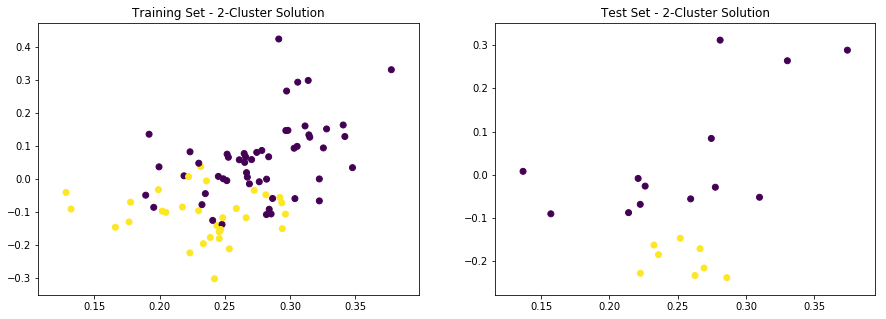

In [54]:
# Plot the first two SVD components
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(svd_frame[0][:84], svd_frame[1][:84], c=y_pred)
plt.title('Training Set - 2-Cluster Solution')

plt.subplot(1,2,2)
plt.scatter(svd_frame[0][84:], svd_frame[1][84:], c=y_pred_test)
plt.title('Test Set - 2-Cluster Solution')
plt.show()

### 3 Clusters
With 3 clusters there is considerable overlap among the clusters, although the approximate regions occupied by each cluster are roughly the same in the training and test cases. At this point there is already a clear lack of coherence in our clustering solution.

In [55]:
# Create a reduced TF-IDF dataframe containing
# this limited feature set
svd_frame = pd.DataFrame(text_tfidf_df_svd)
# Instantiate k-Means
km = KMeans(n_clusters=3, random_state=1)
# Predict clustering for the training and test sets
y_pred = km.fit_predict(text_tfidf_df_84)
y_pred_test = km.predict(text_tfidf_df_21)

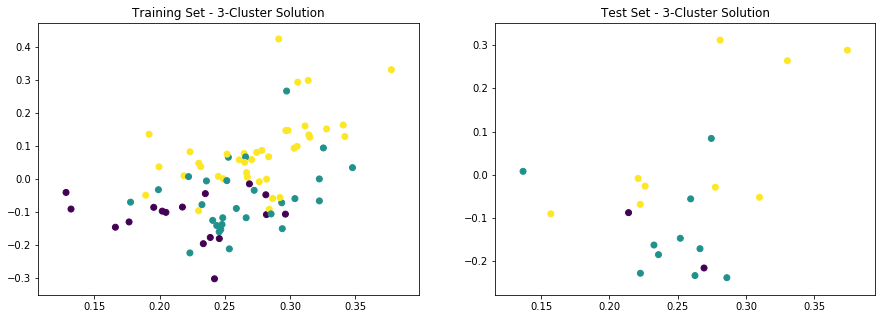

In [56]:
# Plot the first two SVD components
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(svd_frame[0][:84], svd_frame[1][:84], c=y_pred)
plt.title('Training Set - 3-Cluster Solution')

plt.subplot(1,2,2)
plt.scatter(svd_frame[0][84:], svd_frame[1][84:], c=y_pred_test)
plt.title('Test Set - 3-Cluster Solution')
plt.show()

### 4 Clusters
There is a similarly pronounced lack of consistency when 4 clusters are attempted. The training dataset in particular contains clusters that are thoroughly intermixed.

In [57]:
# Create a reduced TF-IDF dataframe containing
# this limited feature set
svd_frame = pd.DataFrame(text_tfidf_df_svd)
# Instantiate k-Means
km = KMeans(n_clusters=4, random_state=1)
# Predict clustering for the training and test sets
y_pred = km.fit_predict(text_tfidf_df_84)
y_pred_test = km.predict(text_tfidf_df_21)

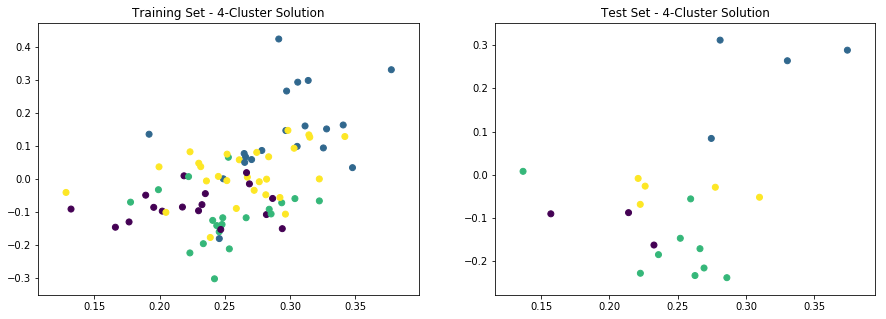

In [58]:
# Plot the first two SVD components
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(svd_frame[0][:84], svd_frame[1][:84], c=y_pred)
plt.title('Training Set - 4-Cluster Solution')

plt.subplot(1,2,2)
plt.scatter(svd_frame[0][84:], svd_frame[1][84:], c=y_pred_test)
plt.title('Test Set - 4-Cluster Solution')
plt.show()

### Methods Having No Ground Truth
So far we have approached this problem by trying to fit clusters to a known classification, whether by genre, author, or collection, or by pre-specifying a suspected number of clusters present in the data. This pre-assigned configuration is known as a ground truth, as explained earlier. As we have seen, this approach has resulted in mixed results. We will now use a couple of methods where there is no ground truth, i.e. the user does not specify a suspected number of clusters. The model is therefore free to define whatever clusters it detects. 

### Mean Shift
Numerous attempts were made to obtain coherent results from this method, by varying the input parameters. Whichever combination of values was tried, however, the model was simply unable to observe any distinctions in the data. This resulted in a single estimated cluster every time.

In [59]:
start_time = time.time()
# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(text_tfidf_df_84, quantile=0.99, n_samples=3)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(text_tfidf_df_84)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Estimated number of clusters: {}".format(n_clusters_))
interval = time.time() - start_time
print('Time taken: {} minutes'.format ('%.1f' % (interval / 60)))

Estimated number of clusters: 1
Time taken: 0.0 minutes


### Affinity Propagation
Using Affinity Propagation, the estimated number of clusters is 14. Recall that in this part of the analysis, we have no ground truth, so we allow the model to return the number of clusters it sees. The Affinity Propagation model is commonly known to perceive a larger number of clusters than most others.

In [60]:
start_time = time.time()
# Instantiate the model and fit it in one statement.
af = AffinityPropagation(damping=0.5, convergence_iter=200).fit(text_tfidf_df_84)
print('Done')

# Pull the number of clusters and cluster assignments for each data point.
centers = af.cluster_centers_indices_
n_clusters_ = len(centers)
labels = af.labels_
# Report results
print('Estimated number of clusters: {}'.format(n_clusters_))
interval = time.time() - start_time
print('Time taken: {} minutes'.format ('%.1f' % (interval / 60)))

Done
Estimated number of clusters: 14
Time taken: 0.0 minutes


#### Cluster Centers
The table below shows the exemplars, or cluster centers, defined by this model. 

In [61]:
# Create dataframe containing cluster centers and their data
centers = af.cluster_centers_indices_
cluster_centers = pd.DataFrame({'title': [title[value] for value in centers],
                                'author': [author[value] for value in centers],
                                'genre': [genre[value] for value in centers],
                                'year': [year[value] for value in centers],
                                'collection': [collection[value] for value in centers]
                               })
# Set desired column order
cols = ['title', 'genre', 'author', 'year', 'collection']
cluster_centers[cols]                                   

,title,genre,author,year,collection
0,a lion and a lioness,detective,Joaquin Miller,1891,11poss
1,a novel in nine letters,misc,fyodor dostoevsky,1847,dostss
2,a witchs den,occult,helena blavatsky,1920,best_psych
3,beyond the bayou,misc,kate chopin,1891,awak_etal
4,desiree's baby,misc,kate chopin,1894,awak_etal
5,ghosts in solid form,occult,gambier bolton,1919,best_psych
6,il conde,misc,joseph conrad,1908,set_six
7,love of life,misc,jack london,1905,jacklss2
8,prints of the city,detective,g daniel flower,1990,unknown
9,the brute,misc,joseph conrad,1906,set_six


#### Evaluate Using Silhouette Score
The silhouette score is a measure of clustering model accuracy. For a given datapoint, the silhouette coefficient denotes the strength of the 'connection' between that datapoint and other datapoints in its cluster, as compared to the strength of its connection to datapoints in other clusters. The mean silhouette coefficient among all points in a dataset (or in a cluster) is its silhouette score. Values range from -1 to +1; a score of +1 would indicate perfectly strong, tightly clustered data, whereas -1 would denote virtually no clustering. Thus the 0.007 value obtained suggests moderately cluster quality, with some degree of overlap between clusters.

In [62]:
# Call cluster assignments for sil.score computation
labels = af.labels_
metrics.silhouette_score(text_tfidf_df_84, labels, metric='euclidean')

0.007159862621783513

In [63]:
indexed_sil_coeffs = list(metrics.silhouette_samples(text_tfidf_df_84, labels, metric='euclidean'))

#### Mean Silhouette Coefficients by Cluster

In [64]:
# Create empty dictionary
dict_sil = {}
# Create a key for each unique cluster
for value in pd.Series(labels).unique():
    dict_sil[value] = []
# For each individual text, append its silhouette coefficient 
# to the cluster to which it belongs
for i in range(len(indexed_sil_coeffs)):
    dict_sil[labels[i]].append(indexed_sil_coeffs[i])
# Compute the mean silhouette coefficient for each cluster
for key in dict_sil:
    dict_sil[key] = np.mean(dict_sil[key])
# Create list of mean sil. coeffs by cluster
avg_sil_coeffs = [dict_sil[key] for key in dict_sil]
# Display the cluster-specific silhouette scores 
pd.DataFrame({'cluster_label':np.arange(len(pd.Series(labels).unique())),
             'avg_silhouette_coeff': avg_sil_coeffs})                              

,avg_silhouette_coeff,cluster_label
0,0.003692,0
1,0.008674,1
2,-0.002922,2
3,0.019791,3
4,0.006453,4
5,0.002733,5
6,0.004642,6
7,-0.003492,7
8,0.012407,8
9,0.104248,9


In [65]:
labels = af.labels_

# Choose author, collection, genre, text, title, or year
# The value of 'categ' below can be changed and the 
# table below will update to reflect the change made
categ = title

clusters = {}
for value in range(len(centers)):
    clusters[value] = []
for i in range(0, len(labels)):
    clusters[labels[i]].append(categ[i])

# Add in dashes for formatting purposes    
max = 0
for key in clusters:
    if len(clusters[key]) > max:
        max = len(clusters[key])        
for key in clusters:
    clusters[key].extend('-' * (max - len(clusters[key])))

#### The 14 Clusters

In [66]:
# Produce table showing the data
# arranged in their respective clusters
df_aff_prop = pd.DataFrame(clusters)
df_aff_prop.loc[:,:7]

,0,1,2,3,4,5,6,7
0,a lion and a lioness,a novel in nine letters,a reflection,beyond the bayou,desiree's baby,a ghost,a lost day,100 west by 53 north
1,an anarchist,after dark,a witchs den,ma'ame pelagie,the gift of the magi,ghosts in solid form,il conde,a day's lodging
2,gaspar ruiz,an unpleasant predicament,brown wolf,-,the mission of jane,nature spirits or elementals,the informer,a thing that glistened
3,israel drake,bobok,the eyes of the panther,-,-,photographing invisible beings,-,love of life
4,ligeia,shall he marry her,-,-,-,some remarkable psychic experiences of famous ...,-,rain dance mechwarrior fan fiction
5,"negore, the coward",the citizen,-,-,-,-,-,the miller's daughter
6,the death of olivier becaille,the crocodile,-,-,-,-,-,-
7,the peasant marey,the gold brick,-,-,-,-,-,-
8,the phantom armies seen in france,the letter,-,-,-,-,-,-
9,-,-,-,-,-,-,-,-


In [67]:
df_aff_prop.loc[:,8:]

,8,9,10,11,12,13
0,a tragedy of high explosives,a smile of fortune,captain burle,a pair of silk stockings,flint and fire,freya of the seven isles
1,accounting for the cards,another man's wife,joseph a story,a respectable woman,the land of heart's desire,strange adventures of a million dollars
2,prints of the city,bitter sweet,once upon a mattress,a traveler in time,the locket,the end of all
3,the dwindling years,gambler's world,the bushwhacker's gratitude,an honest thief,the ordeal at mt hope,the mystic krewe
4,-,his mother's son,the clavecin bruges,expiation,-,-
5,-,the brute,the dream of a ridiculous man,nana,-,-
6,-,the kiss,the heavenly christmas,painkiller,-,-
7,-,the only girl at overlook,-,the awakening,-,-
8,-,the parable of the vain crow,-,the cheated juliet,-,-
9,-,-,-,the descent of man,-,-


#### Further Validation of the Clustering Solution

We see below that some 26% of the pairs in the High Similarity table (i.e. the table of pairs whose cosine similarity is more than 1 standard deviation above the mean) occur in the same cluster. On the other hand, only 2 % of the pairs (i.e. two pairs: The Parable of the Vain Crow, from 620 AD, paired wih Gambler's World, a sci-fi story from 1969, and also with The Kiss, an 1894 romance) in the Low Similarity table occur in the same cluster. This provides a satisfying validation of the clustering arrangement computed by the Affinity Propagation model.

In [68]:
# Define a counter and increment it by one for every
# text-text pair in the high cosine similarity table 
# that both also occur in the same cluster
counter = 0
for row in high_sim_table_84.index:
    text_1 = high_sim_table_84.loc[row, 'text_1']
    text_2 = high_sim_table_84.loc[row, 'text_2']   
    for column in df_aff_prop.columns:
        if (text_1 in list(df_aff_prop.loc[:,column])) & (text_2 in list(df_aff_prop.loc[:,column])):            
            counter += 1
# Display proportion of these pairs that are in the same cluster
counter / len(high_sim_table_84)

0.26380368098159507

In [69]:
# Define a counter and increment it by one for every
# text-text pair in the low cosine similarity table 
# that both also occur in the same cluster
counter = 0
for row in low_sim_table_84.index:
    text_1 = low_sim_table_84.loc[row, 'text_1']
    text_2 = low_sim_table_84.loc[row, 'text_2']   
    for column in df_aff_prop.columns:
        if (text_1 in list(df_aff_prop.loc[:,column])) & (text_2 in list(df_aff_prop.loc[:,column])):            
# There shouldn't be many of these so let's print them 
            print('\n', text_1, '**', text_2)
            counter += 1
# Display proportion of these pairs that are in the same cluster
counter / len(low_sim_table_84)


 gambler's world ** the parable of the vain crow

 the kiss ** the parable of the vain crow


0.02531645569620253

#### Assigning the Test Texts to Existing Clusters
We next use logistic regression to predict which of the 14 clusters each text in the test dataset should go into. The ad-hoc nature of this step should be kept in mind; if the original clustering analysis had been done on the entire dataset, our solution would have been different, likely with more than 14 clusters. 

### Logistic Regression

In [70]:
# Define a dataframe containing only the test data
text_tfidf_df_21 = text_tfidf_df[84:]
# Instantiate and fit the logistic regression model with no penalty
lr = linear_model.LogisticRegression(C=1e9, random_state=4)
lr.fit(text_tfidf_df_84, labels)
# Predict clusters for these test data
y_pred = lr.predict(text_tfidf_df_21)

#### Silhouette Score
Below is the silhouette score for the overall corpus, as computed after the test data have been allocated to existing clusters using logistic regression. 
The score has decreased only marginally, from 0.0072 to 0.0068. This confirms that this updated clustering configuration is almost as robust as the original solution.

In [71]:
label_list = list(labels)
y_pred_list = list(y_pred)
# Define a list of cluster labels containing the full dataset
# (not just the training or test data this time)
labels_full = (label_list + y_pred_list)
metrics.silhouette_score(text_tfidf_df, labels_full, metric='euclidean')

0.0068131042440937742

#### How Have the Individual Scores Changed?
Now that the test data have been included, we see below the original silhouette scores by cluster, alongside the new scores and the change in score. Although the overall silhouette score has decreased marginally, 8 of the original 14 clusters have actually had an increase in their silhouette scores. 

In [72]:
# Silhouette coeffs for each individual datapoint
indexed_sil_coeffs_f = list(metrics.silhouette_samples
                            (text_tfidf_df, labels_full, metric='euclidean'))
# Create empty dictionary
dict_sil_f = {}
# Create a dict key for each cluster label
for value in pd.Series(labels_full).unique():
    dict_sil_f[value] = []
# Append individual sil. coeffs to the appropriate cluster list    
for i in range(len(indexed_sil_coeffs_f)):
    dict_sil_f[labels_full[i]].append(indexed_sil_coeffs_f[i])

# Compute mean silhouette score by cluster
for key in dict_sil_f:
    dict_sil_f[key] = np.mean(dict_sil_f[key])
# Create a list of mean sil. scores by cluster
avg_sil_coeffs_f = [dict_sil_f[key] for key in dict_sil_f]
# Create another list denoting whether score has improved or not
improvement_list = ['Y' if avg_sil_coeffs_f[i] > avg_sil_coeffs[i] 
                    else 'N' for i in range(len(avg_sil_coeffs_f))]
delta_list = [avg_sil_coeffs_f[i] - avg_sil_coeffs[i] for i in range(len(avg_sil_coeffs_f))]

# Collate and display results
final_table = pd.DataFrame({'cluster_label':np.arange(len(pd.Series(labels).unique())),
             'silhouette_score_orig': avg_sil_coeffs,
             'silhouette_score_fin': avg_sil_coeffs_f,
             'delta': delta_list,
             'improvement?':improvement_list})

display(final_table.iloc[:,[0,4,3,1,2]])

,cluster_label,silhouette_score_orig,silhouette_score_fin,delta,improvement?
0,0,0.003692,0.006037,0.002345,Y
1,1,0.008674,0.008283,-0.000392,N
2,2,-0.002922,-0.000556,0.002366,Y
3,3,0.019791,0.020268,0.000477,Y
4,4,0.006453,0.004814,-0.001639,N
5,5,0.002733,0.005331,0.002598,Y
6,6,0.004642,0.002754,-0.001888,N
7,7,-0.003492,-0.004038,-0.000546,N
8,8,0.012407,0.014682,0.002275,Y
9,9,0.104248,0.104248,0.000000,N


# Summary

We can summarize the findings from this study as follows:
-  It is possible to model and group a corpus of short stories using TF-IDF and the Affinity Propagation clustering model.
-  This combination of techniques on the training set produced a moderate solution with some overlap between clusters, having an aggregate silhouette score close to zero.
-  Using logistic regression to cluster the holdout data into the existing groups, proved successful, with a negligible reduction in the overall silhouette score. In fact, 8 of the 14 clusters experienced an improvement in their mean silhouette coefficient after the holdout data had been added. 
-  Ground Truth clustering models were not effective in clustering the data according to genre, collection or author.
-  However, some success was found using a K-Means solution specifying 2 and to some extent 3 clusters, as evidenced by plots of the first two SVD-reduced components of these data on x-y axes. These solutions showed reasonable consistency between the training and test sets.

# Limitations

The main limitations of this study were:
-  Only the first 6000 characters of each text were used. Better solutions, or further insights, may have been obtained if a larger portion of each text had been considered. Also, it would have been nice to have used a larger corpus of texts. Conversely, it could be that using more texts, or a larger portion of each text does not produce a discernible gain in the quality of the results. That in itself would have been a noteworthy finding; but the level of detail in the analysis had to be tailored to the available time and CPU power.
-  There was a slight lack of familiarity with the texts used. This may have led to some inaccuracies in classifying texts as 'misc', for example, where some may perhaps have fit better into another category. A better classification might possibly have led to a better genre-specific clustering outcome.